In [1]:
# Import necessary libraries
import cdflib
import xarray as xr
import os
import urllib.request
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import math

import sys
import h5py
import dask
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline
import h5netcdf
import flox
import importlib as il 
import ecef_geodetic

In [2]:
fname = ['GR_OPER_TEC1TMS_2F_20130316T000000_20130316T235959_0101.cdf', 'GR_OPER_TEC1TMS_2F_20130317T000000_20130317T235959_0101.cdf', 'GR_OPER_TEC1TMS_2F_20130318T000000_20130318T235959_0101.cdf', 'GR_OPER_TEC2TMS_2F_20130316T000000_20130316T235959_0101.cdf', 'GR_OPER_TEC2TMS_2F_20130317T000000_20130317T235959_0101.cdf', 'GR_OPER_TEC2TMS_2F_20130318T000000_20130318T235959_0101.cdf']
grace_data = []


# Adding the local time
ecef_geodetic = il.reload(ecef_geodetic)


for f in tqdm(fname):
    path = 'ESA_GRACE_data/' + f
    data = xr.Dataset()
    d = cdflib.CDF(path)

    step = range(len(d['Timestamp']))
    
    for var_name in d.cdf_info().zVariables:
        
        var_data = d[var_name]

        if var_name == 'DCB' or var_name == 'DCB_Error' :
            data[var_name] = d[var_name]
        
        elif type(var_data[0]) == np.ndarray:
            var_name1 = var_name + '_X'
            var_name2 = var_name + '_Y'
            var_name3 = var_name + '_Z'
            data[var_name1] = ('step', [i for i,j,k in var_data], {'step': step})
            data[var_name2] = ('step', [j for i,j,k in var_data], {'step': step})
            data[var_name3] = ('step', [k for i,j,k in var_data], {'step': step})

        else:
            data[var_name] = ('step', var_data, {'step': step})


    d0 = dt.datetime.strptime(f.split('_')[4], '%Y%m%dT%f')
    date = [d0 + pd.Timedelta(milliseconds = (i - data.Timestamp[0].values)) for i in data.Timestamp.values]
    data['date'] = ('step', [i for i in date], {'step': step})
    lt = ecef_geodetic.ut_to_lt(date, data['Longitude'].values)
    data['LT'] = ('step', lt, {'step':step})
    
    grace_data.append(data)

print()
print('Columns in Satellite Data: \n', d.cdf_info().zVariables)
print()
print(data)


100%|█████████████████████████████████████████████| 6/6 [00:25<00:00,  4.30s/it]


Columns in Satellite Data: 
 ['Timestamp', 'Latitude', 'Longitude', 'Radius', 'GPS_Position', 'LEO_Position', 'PRN', 'L1', 'L2', 'P1', 'P2', 'S1_C_N0', 'S2_C_N0', 'Absolute_STEC', 'Absolute_VTEC', 'Elevation_Angle', 'Relative_STEC', 'Relative_STEC_RMS', 'DCB', 'DCB_Error']

<xarray.Dataset>
Dimensions:            (step: 56708)
Dimensions without coordinates: step
Data variables: (12/26)
    Timestamp          (step) float64 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 -60.57 -60.57 -60.57 ... 26.16 26.16 26.16
    Longitude          (step) float64 -175.0 -175.0 -175.0 ... 2.732 2.732 2.732
    Radius             (step) float64 6.825e+06 6.825e+06 ... 6.822e+06
    GPS_Position_X     (step) float64 -3.798e+06 -1.924e+07 ... 2.534e+07
    GPS_Position_Y     (step) float64 -1.475e+07 1.345e+07 ... -7.897e+06
    ...                 ...
    Relative_STEC      (step) float64 86.47 56.26 80.43 ... 46.5 52.91 37.42
    Relative_STEC_RMS  (step) float64 0.7086 0.870

In [3]:
grace_data[0].data_vars

Data variables:
    Timestamp          (step) float64 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 -56.91 -56.91 -56.91 ... 88.52 88.52 88.52
    Longitude          (step) float64 3.965 3.965 3.965 ... 45.42 45.42 45.42
    Radius             (step) float64 6.833e+06 6.833e+06 ... 6.806e+06
    GPS_Position_X     (step) float64 8.967e+05 9.566e+06 ... 8.504e+06 1.51e+07
    GPS_Position_Y     (step) float64 -1.838e+07 2.261e+07 ... -5.75e+06
    GPS_Position_Z     (step) float64 -1.952e+07 -1.043e+07 ... 2.072e+07
    LEO_Position_X     (step) float64 3.721e+06 3.721e+06 ... 1.237e+05
    LEO_Position_Y     (step) float64 2.579e+05 2.579e+05 ... 1.255e+05
    LEO_Position_Z     (step) float64 -5.725e+06 -5.725e+06 ... 6.804e+06
    PRN                (step) uint16 11 12 14 18 11 12 14 ... 10 13 16 23 29 30
    L1                 (step) float64 2.346e+07 2.354e+07 ... 2.134e+07
    L2                 (step) float64 2.346e+07 2.354e+07 ... 2.134e+07
    P1     

### Note
- LEO_Position given in the data are the positions of the GRACE satellite in the ECEF cartesian system (WGS84 is being used) and units are in meters
- GPS_Position given in the data are the positions of the GPS satellites
- Latitude, Longitude, and Radius represent the position of the GRACE satellite and they are in the spherical coordinates system (Geocentric or ECEF spherical system)
- Absolute VTEC is recommended to be calculated by using GPS rays of elevation angle as at least 50 degrees (in documentation).

In [4]:
d1 = grace_data[4]

selsd = d1.where(d1.Timestamp <= d1.Timestamp.values[1600], drop=True) 
# number in Timestamp.values[...] is used to separate just one pass out of the multiple passes

print('Unique Timestamps -', len(np.unique(selsd.Timestamp.values)))
print('Unique PRN -', np.unique(selsd.PRN))

Unique Timestamps - 225
Unique PRN - [ 1.  2.  4.  5.  7.  8.  9. 10. 13. 16. 17. 20. 23. 24. 26. 28. 29. 30.
 32.]


In [5]:
print(d1)

<xarray.Dataset>
Dimensions:            (step: 57724)
Dimensions without coordinates: step
Data variables: (12/26)
    Timestamp          (step) float64 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 87.54 87.54 87.54 ... -58.65 -58.65 -58.65
    Longitude          (step) float64 161.1 161.1 161.1 ... -175.0 -175.0 -175.0
    Radius             (step) float64 6.806e+06 6.806e+06 ... 6.824e+06
    GPS_Position_X     (step) float64 -6.162e+06 -1.977e+07 ... -2.015e+07
    GPS_Position_Y     (step) float64 1.532e+07 -7.415e+06 ... -9.618e+06
    ...                 ...
    Relative_STEC      (step) float64 43.19 45.08 58.87 ... 42.21 52.95 42.59
    Relative_STEC_RMS  (step) float64 0.4811 0.3469 0.218 ... 1.884 0.2287
    DCB                float64 -39.07
    DCB_Error          float64 1.98
    date               (step) datetime64[ns] 2013-03-17 ... 2013-03-17T23:59:30
    LT                 (step) float64 10.74 10.74 10.74 ... 12.32 12.32 12.32


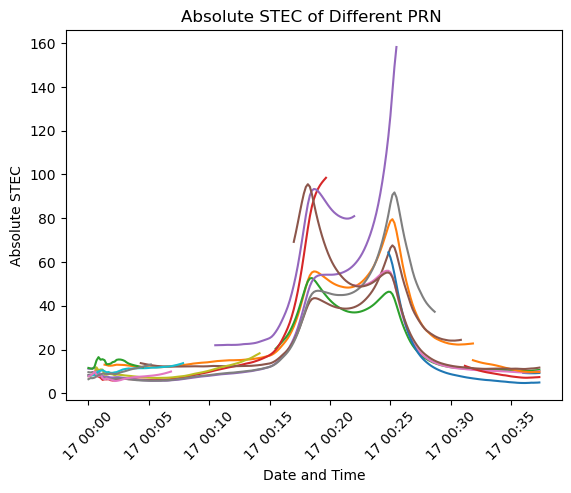

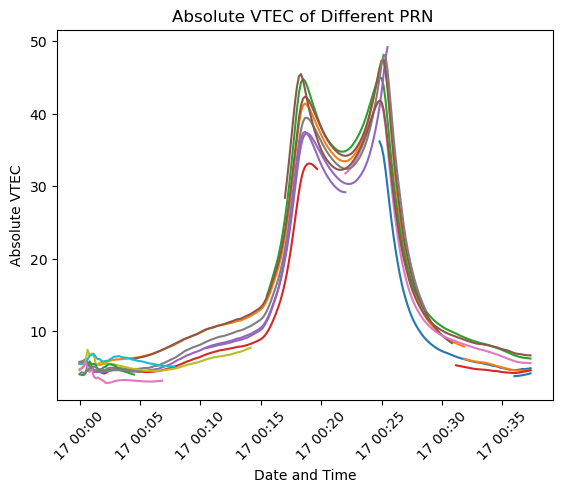

In [6]:
for prn in np.unique(selsd.PRN):

    seld2 = selsd.where(selsd.PRN == prn, drop = True)
    
    plt.plot(seld2.date, seld2.Absolute_STEC)
    plt.xticks(rotation=45)
    plt.xlabel('Date and Time')
    plt.ylabel('Absolute STEC')
    plt.title('Absolute STEC of Different PRN ')

plt.show()


for prn in np.unique(selsd.PRN):

    seld2 = selsd.where(selsd.PRN == prn, drop = True)
    
    plt.plot(seld2.date, seld2.Absolute_VTEC)
    plt.xticks(rotation=45)
    plt.xlabel('Date and Time')
    plt.ylabel('Absolute VTEC')
    plt.title('Absolute VTEC of Different PRN ')

plt.show()

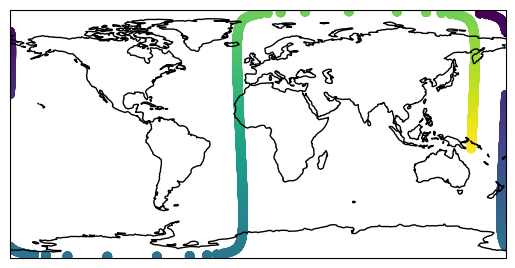

In [7]:
ax = plt.subplot(projection=ccrs.PlateCarree())


ma = 5000

ax.scatter(d1.Longitude.values[:ma], d1.Latitude.values[:ma], c=d1.Timestamp.values[:ma])

ax.coastlines()


In [8]:
d1.data_vars

Data variables:
    Timestamp          (step) float64 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 87.54 87.54 87.54 ... -58.65 -58.65 -58.65
    Longitude          (step) float64 161.1 161.1 161.1 ... -175.0 -175.0 -175.0
    Radius             (step) float64 6.806e+06 6.806e+06 ... 6.824e+06
    GPS_Position_X     (step) float64 -6.162e+06 -1.977e+07 ... -2.015e+07
    GPS_Position_Y     (step) float64 1.532e+07 -7.415e+06 ... -9.618e+06
    GPS_Position_Z     (step) float64 2.075e+07 1.633e+07 ... -1.393e+07
    LEO_Position_X     (step) float64 -2.763e+05 -2.763e+05 ... -3.538e+06
    LEO_Position_Y     (step) float64 9.468e+04 9.468e+04 ... -3.076e+05
    LEO_Position_Z     (step) float64 6.799e+06 6.799e+06 ... -5.828e+06
    PRN                (step) uint16 5 7 10 13 16 23 29 ... 20 28 1 9 17 20 28
    L1                 (step) float64 2.158e+07 2.29e+07 ... 2.331e+07 2.063e+07
    L2                 (step) float64 2.158e+07 2.29e+07 ... 2.331e+07 2.06

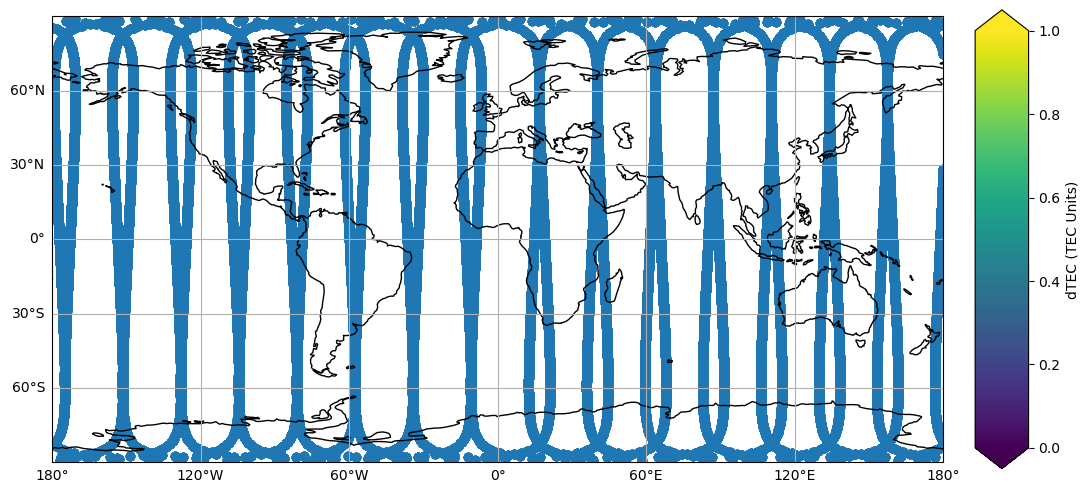

In [9]:

fig, axs = plt.subplots(1, 2, width_ratios=(1,.06), figsize=(11,5), 
                        subplot_kw={'projection':ccrs.PlateCarree()})
# ax0 = fig.add_subplot(1,5,, projection=ccrs.PlateCarree())

axs[1].remove()
axs[1] = fig.add_subplot(1,2,2)


f = axs[0].scatter(d1.Longitude, d1.Latitude)

axs[0].coastlines()
axs[0].gridlines(draw_labels=['bottom', 'left'])

plt.colorbar(f, cax=axs[1], label='dTEC (TEC Units)', extend='both')

# axs[0].ccrs.PlateCarree()

fig.tight_layout()
fig.show();

In [10]:
print(math.degrees(math.atan(1)))

45.0


In [11]:
import ecef_geodetic
import importlib as il

ecef_geodetic = il.reload(ecef_geodetic)

lat_gps = []
lon_gps = []
alt_gps = []

lat_leo = []
lon_leo = []
alt_leo = []

x_geod = []
y_geod = []
z_geod = []

radius_check = []

for x,y,z in tqdm(zip(d1.GPS_Position_X, d1.GPS_Position_Y, d1.GPS_Position_Z)):
    lat, lon, alt = ecef_geodetic.ecef_to_lla(x,y,z)
    lat_gps.append(lat)
    lon_gps.append(lon)
    alt_gps.append(alt)

for x,y,z in tqdm(zip(d1.LEO_Position_X, d1.LEO_Position_Y, d1.LEO_Position_Z)):
    lat, lon, alt = ecef_geodetic.cart_spher(x,y,z)
    lat_leo.append(lat)
    lon_leo.append(lon)
    alt_leo.append(alt)

for lat,lon,h in tqdm(zip(d1.Latitude, d1.Longitude, d1.Radius)):
    x, y, z = ecef_geodetic.spher_cart(lat,lon,h)
    x_geod.append(x)
    y_geod.append(y)
    z_geod.append(z)

d1['GPS_lat'] = ('step', lat_gps, {'step': step})
d1['GPS_lon'] = ('step', lon_gps, {'step': step})
d1['GPS_alt'] = ('step', alt_gps, {'step': step})
d1['LEO_lat'] = ('step', lat_leo, {'step': step})
d1['LEO_lon'] = ('step', lon_leo, {'step': step})
d1['LEO_alt'] = ('step', alt_leo, {'step': step})
d1['Geod_X'] = ('step', x_geod, {'step': step})
d1['Geod_Y'] = ('step', y_geod, {'step': step})
d1['Geod_Z'] = ('step', z_geod, {'step': step})

57724it [00:20, 2807.73it/s]
57724it [01:19, 722.67it/s]
57724it [00:17, 3375.67it/s]


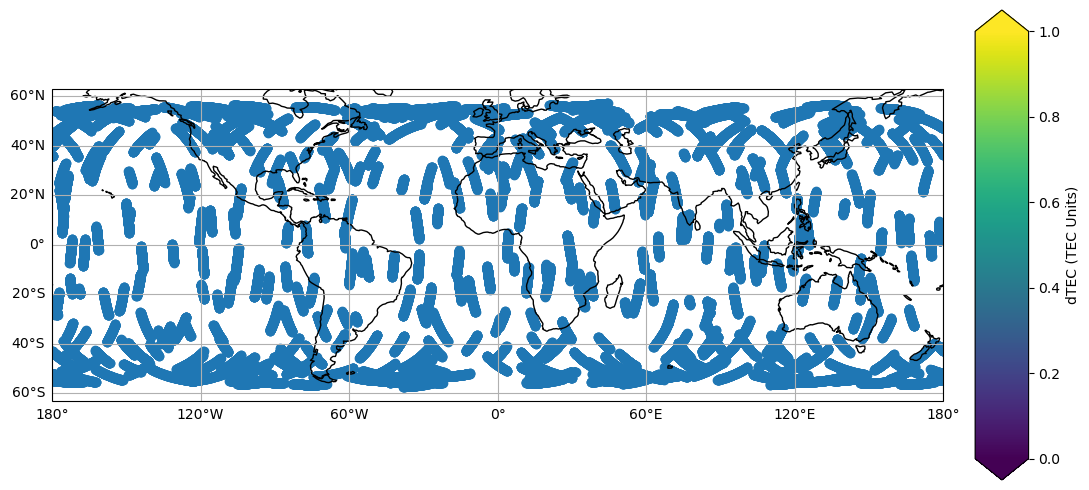

In [12]:

fig, axs = plt.subplots(1, 2, width_ratios=(1,.06), figsize=(11,5), 
                        subplot_kw={'projection':ccrs.PlateCarree()})
# ax0 = fig.add_subplot(1,5,, projection=ccrs.PlateCarree())

axs[1].remove()
axs[1] = fig.add_subplot(1,2,2)


f = axs[0].scatter(d1.GPS_lon, d1.GPS_lat)

axs[0].coastlines()
axs[0].gridlines(draw_labels=['bottom', 'left'])

plt.colorbar(f, cax=axs[1], label='dTEC (TEC Units)', extend='both')

# axs[0].ccrs.PlateCarree()

fig.tight_layout()
fig.show();

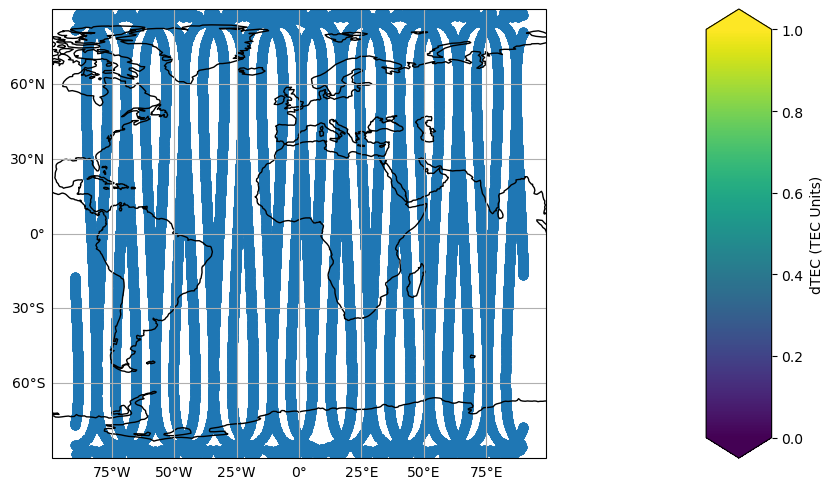

In [13]:

fig, axs = plt.subplots(1, 2, width_ratios=(1,.06), figsize=(11,5), 
                        subplot_kw={'projection':ccrs.PlateCarree()})
# ax0 = fig.add_subplot(1,5,, projection=ccrs.PlateCarree())

axs[1].remove()
axs[1] = fig.add_subplot(1,2,2)


f = axs[0].scatter(d1.LEO_lon, d1.LEO_lat)

axs[0].coastlines()
axs[0].gridlines(draw_labels=['bottom', 'left'])

plt.colorbar(f, cax=axs[1], label='dTEC (TEC Units)', extend='both')

# axs[0].ccrs.PlateCarree()

fig.tight_layout()
fig.show();

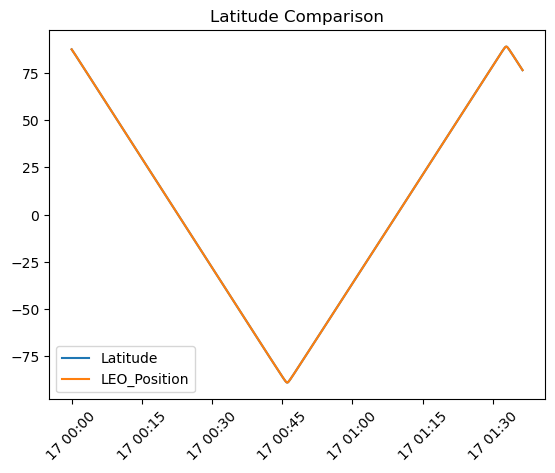

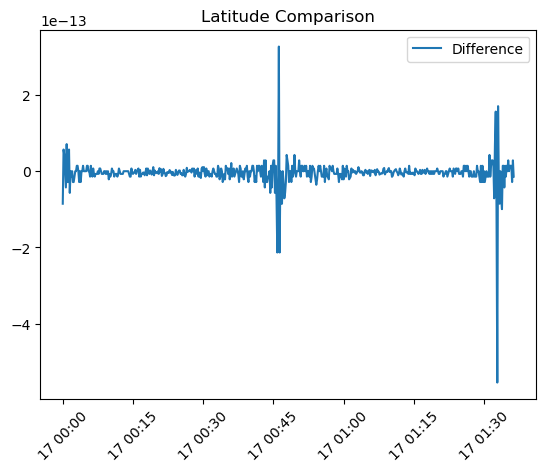

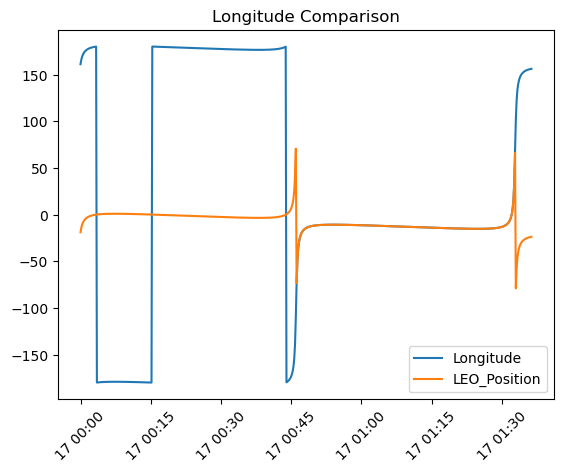

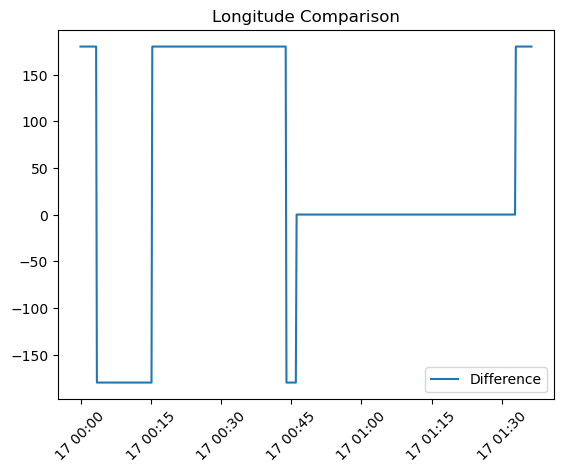

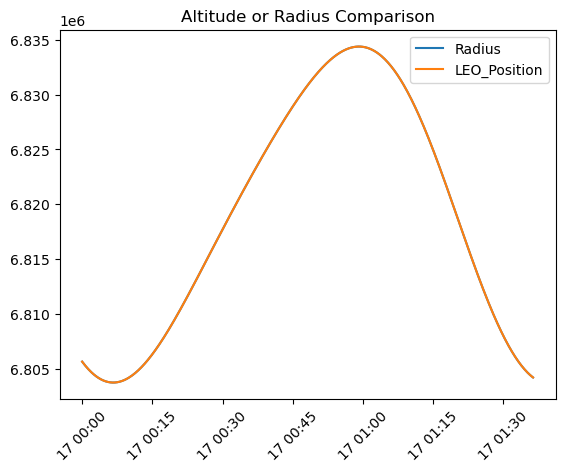

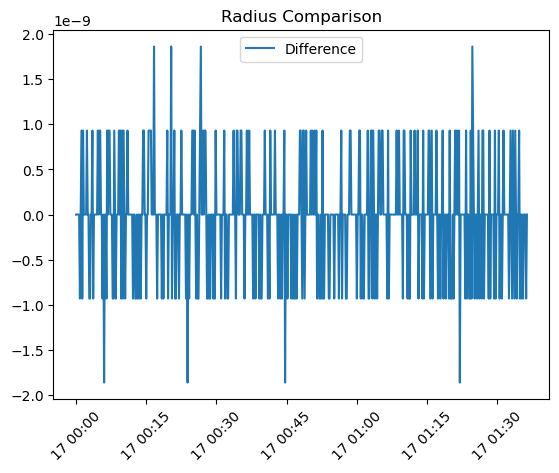

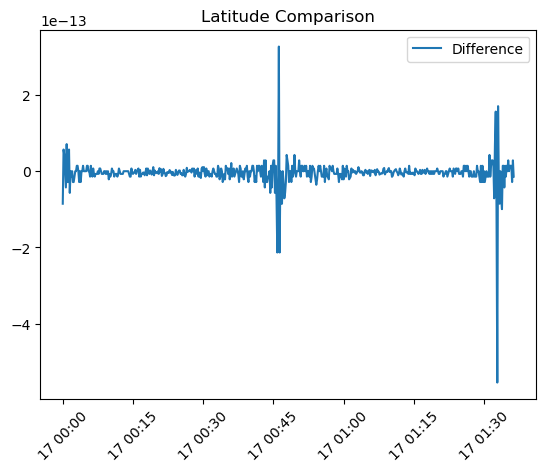

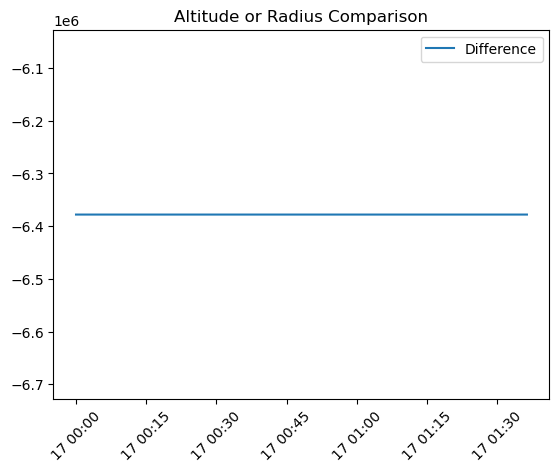

In [14]:
a = 0
b = 4000

plt.figure()
plt.plot(d1.date[a:b], d1.Latitude.values[a:b], label='Latitude')
plt.plot(d1.date[a:b], d1.LEO_lat.values[a:b], label='LEO_Position')
plt.title('Latitude Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Latitude.values[a:b] - d1.LEO_lat.values[a:b], label='Difference')
plt.title('Latitude Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Longitude.values[a:b], label='Longitude')
plt.plot(d1.date[a:b], d1.LEO_lon.values[a:b], label='LEO_Position')
plt.title('Longitude Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Longitude.values[a:b] - d1.LEO_lon.values[a:b], label='Difference')
plt.title('Longitude Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Radius.values[a:b], label='Radius')
plt.plot(d1.date[a:b], d1.LEO_alt.values[a:b], label='LEO_Position')
plt.title('Altitude or Radius Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Radius.values[a:b] - d1.LEO_alt.values[a:b], label='Difference')
plt.title('Radius Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()



plt.figure()
plt.plot(d1.date[a:b], d1.Latitude.values[a:b] - d1.LEO_lat.values[a:b], label='Difference')
plt.title('Latitude Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()


plt.figure()
plt.plot(d1.date[a:b], d1.Radius.values[a:b] - (d1.LEO_alt.values[a:b] + 6378000), label='Difference')
plt.title('Altitude or Radius Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

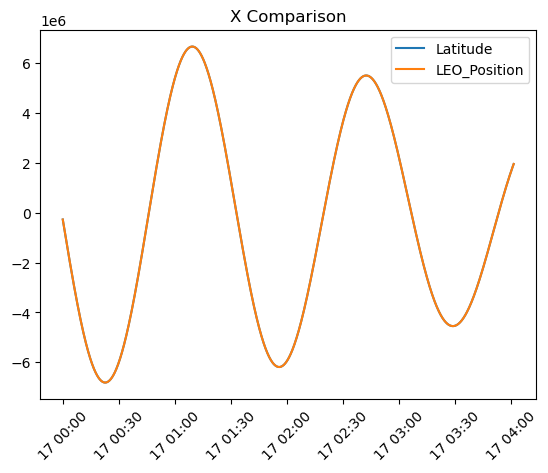

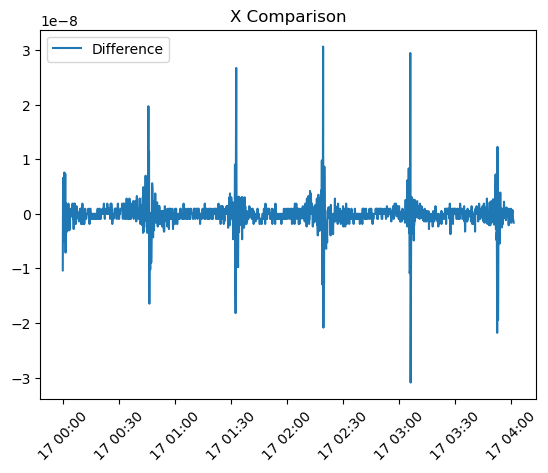

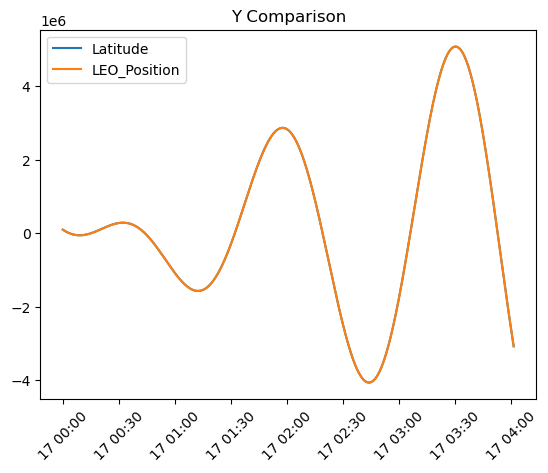

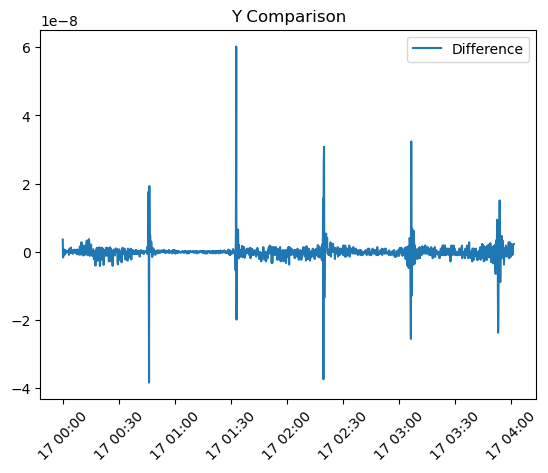

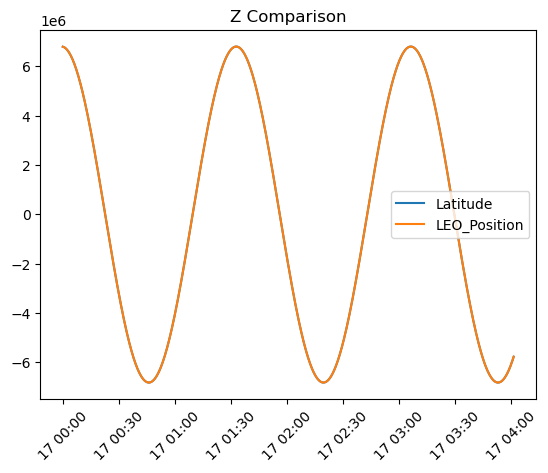

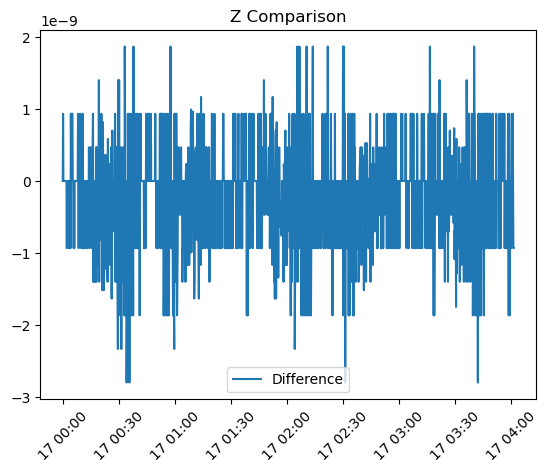

In [15]:
a = 0
b = 10000

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_X.values[a:b], label='Latitude')
plt.plot(d1.date[a:b], d1.LEO_Position_X.values[a:b], label='LEO_Position')
plt.title('X Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_X.values[a:b] - d1.LEO_Position_X.values[a:b], label='Difference')
plt.title('X Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_Y.values[a:b], label='Latitude')
plt.plot(d1.date[a:b], d1.LEO_Position_Y.values[a:b], label='LEO_Position')
plt.title('Y Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_Y.values[a:b] - d1.LEO_Position_Y.values[a:b], label='Difference')
plt.title('Y Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_Z.values[a:b], label='Latitude')
plt.plot(d1.date[a:b], d1.LEO_Position_Z.values[a:b], label='LEO_Position')
plt.title('Z Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_Z.values[a:b] - d1.LEO_Position_Z.values[a:b], label='Difference')
plt.title('Z Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

'''
plt.figure()
plt.plot(d1.date[a:b], d1.Radius[a:b], label='Radius Given')
plt.plot(d1.date[a:b], d1.Radius_check[a:b], label='Radius Calculated')
plt.title('Radius Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Radius[a:b] - d1.Radius_check[a:b], label='Difference')
plt.title('Radius Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()
''';

In [16]:

# Rough  - for testing code

y = np.array([1,2,3,9,15,16,17,18,19,20,31,32,33,44,105])
split = np.where(np.diff(y) > 3)
print(split)
for s in split:
    print(y[s])


sel = np.where(np.diff(y) > 2)
print(len(sel[0]), sel)
yn = np.split(y, sel[0]+1)
print(yn)

(array([ 2,  3,  9, 12, 13]),)
[ 3  9 20 33 44]
5 (array([ 2,  3,  9, 12, 13]),)
[array([1, 2, 3]), array([9]), array([15, 16, 17, 18, 19, 20]), array([31, 32, 33]), array([44]), array([105])]


In [17]:

# Rough - for testing code

dn = d1.groupby('PRN') # 1, 24, 27 PRN is not present in grace_data[0]
prn = np.unique(d1.PRN)

print(dn)
print()

# All the timestamps are at the gap of 10 seconds
print(np.unique(d1.date.dt.time.values)[:10])

r = d1.date[:10]
print(r)
splits = np.where(np.diff(r.dt.second.values) > 5)
print(splits)

DatasetGroupBy, grouped over 'PRN'
30 groups with labels 1, 2, 3, 4, 5, 7, ..., 28, 29, 30, 31, 32.

[datetime.time(0, 0) datetime.time(0, 0, 10) datetime.time(0, 0, 20)
 datetime.time(0, 0, 30) datetime.time(0, 0, 40) datetime.time(0, 0, 50)
 datetime.time(0, 1) datetime.time(0, 1, 10) datetime.time(0, 1, 20)
 datetime.time(0, 1, 30)]
<xarray.DataArray 'date' (step: 10)>
array(['2013-03-17T00:00:00.000000000', '2013-03-17T00:00:00.000000000',
       '2013-03-17T00:00:00.000000000', '2013-03-17T00:00:00.000000000',
       '2013-03-17T00:00:00.000000000', '2013-03-17T00:00:00.000000000',
       '2013-03-17T00:00:00.000000000', '2013-03-17T00:00:00.000000000',
       '2013-03-17T00:00:10.000000000', '2013-03-17T00:00:10.000000000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: step
Attributes:
    step:     range(0, 57724)
(array([7]),)


In [21]:
#print(len(np.unique((d1.LEO_Position_X.values))))
#print(len(np.unique((d1.LEO_Position_Y.values))))
#print(len(np.unique((d1.LEO_Position_Z.values))))

# first finding it for just one pass = 1600
d2 = d1
#d2 = d1.where(d1.Timestamp <= d1.Timestamp.values[20000], drop=True) 
print(np.unique(d2.PRN))

ecef_geodetic = il.reload(ecef_geodetic)

# 1600 is the number of points in one pass
xout = pd.date_range(d2.date.min().values, d2.date.max().values, 28800)
print(xout[0], xout[-1])

out_time = []
out_lt = []
out_lat = []
out_lon = []
out_stec = []
out_sdtec = []
out_vtec = []
out_prn = []
out_sdtec_perc = []
#out_vdtec = []

skipped=0
skip = False 

    
d3 = list(d2.groupby('PRN'))

for sat_num, d5 in d3:
    print('start')
    first = True
    #print(d5.date.values)
    splits = np.where(np.diff((60*d5.date.dt.hour.values) + (d5.date.dt.minute.values) ) > 1) # Split if there is a break of more than 5 minutes
    print(splits)

    for s in splits:
        data = {}

        for v in d5.data_vars:
            if v == 'DCB' or v == 'DCB_Error':
                continue
            data[v] = np.split(d5[v].values, s+1)
        #print(data['Absolute_STEC'][0])
            
        for ipass in range(len(data['Absolute_STEC'])):
            
            sel = np.where(data['Absolute_STEC'][ipass] > 1)

            if len(sel[0]) > 20:
                xin = data['date'][ipass][sel]
                num_secs = pd.Timedelta(xin[-1] - xin[0]).total_seconds()

                if num_secs > 600: 
                    # So at least 10 min of data should be there in each segment
                    yin = data['Absolute_STEC'][ipass][sel]
                    ylat = data['Latitude'][ipass][sel]
                    print('Sat_num', int(sat_num), 'segment_len', int(num_secs/60), 'min')
                    
                    _,in_indx = np.unique(xin,return_index=True)
                    if len(in_indx) != len(xin):
                        skip = True
                        skipped += 1
                        continue
                    
                    
                    yout = CubicSpline(xin, yin)(xout, extrapolate=False)
                    #print(xin, xout)
                    x_out = []
                    y_out = []




                    
                    elev = 0
                    for e in data['Elevation_Angle'][ipass][sel]:
                        if e < 50:
                            elev += 1
                    print('elev out of bound =', elev, ', seg size =', len(data['Elevation_Angle'][ipass][sel]))





                    
                    for i in range(len(yout)):
                        if not np.isnan(yout[i]):
                            x_out.append(xout[i])
                            y_out.append(yout[i])
                    
                    out_time.append(x_out)
                    out_stec.append(y_out)
                    
                    fit = np.empty(len(y_out))
                    fit = savgol_filter(y_out, 60, 1, mode='interp')
                    out_sdtec.append(y_out - fit)
                    out_prn.append(int(sat_num))


                    x_in = xin.astype(np.int64) // 10**9
                    x_out2 = [i.timestamp() for i in x_out]
                    #print(x_in[0], type(x_in[0]), x_out[0], type(x_out[0]))
                    
                    #print(data['Latitude'][ipass][sel])
                    
                    out_lat.append(CubicSpline(x_in, data['Latitude'][ipass][sel])(x_out2))
                    #print(out_lat[-1])
                    out_lon.append(CubicSpline(x_in, data['Longitude'][ipass][sel])(x_out2))

                    x_out_lt = []
                    for ij in range(len(x_out)):
                        #print(type(x_out[ij]))
                        temp = x_out[ij].to_pydatetime()
                        x_out_lt.append(temp)
                    #print(x_out_lt[0], x_out[0])
                    
                    local = ecef_geodetic.ut_to_lt(x_out_lt[:2], out_lon[-1][:2])
                    #print(local)
                    out_lt.append(local)
                    #out_time.append(CubicSpline(xin, data['date'][ipass][sel])(x_out, extrapolate=False))
                    out_vtec.append(CubicSpline(x_in, data['Absolute_VTEC'][ipass][sel])(x_out2))
                    
                    #out_vdtec.append(CubicSpline(xin, data['los_tec'][ipass][sel])(xout, extrapolate=False))
                    
                else:
                    skipped += 1
                    
            else:
                skipped += 1
                    
print(skipped, 'skipped')

[ 1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 28 29 30 31 32]
2013-03-17 00:00:00 2013-03-17 23:59:30
start
(array([ 179,  367,  470,  609,  734,  939, 1097, 1276, 1470, 1610, 1786,
       1968, 2131]),)
Sat_num 1 segment_len 29 min
elev out of bound = 180 , seg size = 180
Sat_num 1 segment_len 31 min
elev out of bound = 115 , seg size = 188
Sat_num 1 segment_len 17 min
elev out of bound = 54 , seg size = 93
Sat_num 1 segment_len 23 min
elev out of bound = 139 , seg size = 139
Sat_num 1 segment_len 20 min
elev out of bound = 125 , seg size = 125
Sat_num 1 segment_len 34 min
elev out of bound = 100 , seg size = 205
Sat_num 1 segment_len 26 min
elev out of bound = 100 , seg size = 158


/tmp/ipykernel_179402/1855120312.py:117: UserWarning: Discarding nonzero nanoseconds in conversion.
  temp = x_out[ij].to_pydatetime()


Sat_num 1 segment_len 29 min
elev out of bound = 179 , seg size = 179
Sat_num 1 segment_len 32 min
elev out of bound = 99 , seg size = 194
Sat_num 1 segment_len 23 min
elev out of bound = 53 , seg size = 140
Sat_num 1 segment_len 29 min
elev out of bound = 176 , seg size = 176
Sat_num 1 segment_len 30 min
elev out of bound = 111 , seg size = 182
Sat_num 1 segment_len 27 min
elev out of bound = 59 , seg size = 163
start
(array([ 183,  393,  571,  736,  934, 1144, 1337, 1506, 1703, 1901, 2095,
       2298, 2507]),)
Sat_num 2 segment_len 30 min
elev out of bound = 184 , seg size = 184
Sat_num 2 segment_len 34 min
elev out of bound = 105 , seg size = 210
Sat_num 2 segment_len 29 min
elev out of bound = 139 , seg size = 178
Sat_num 2 segment_len 27 min
elev out of bound = 165 , seg size = 165
Sat_num 2 segment_len 32 min
elev out of bound = 101 , seg size = 198
Sat_num 2 segment_len 34 min
elev out of bound = 123 , seg size = 210
Sat_num 2 segment_len 32 min
elev out of bound = 193 , seg si

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 2

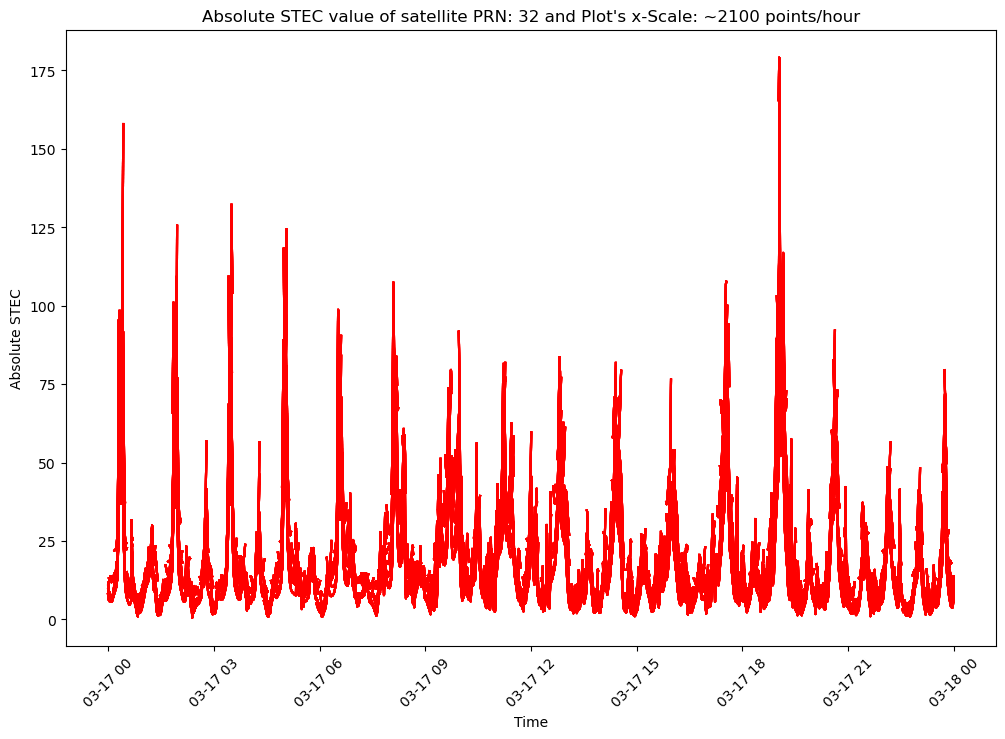

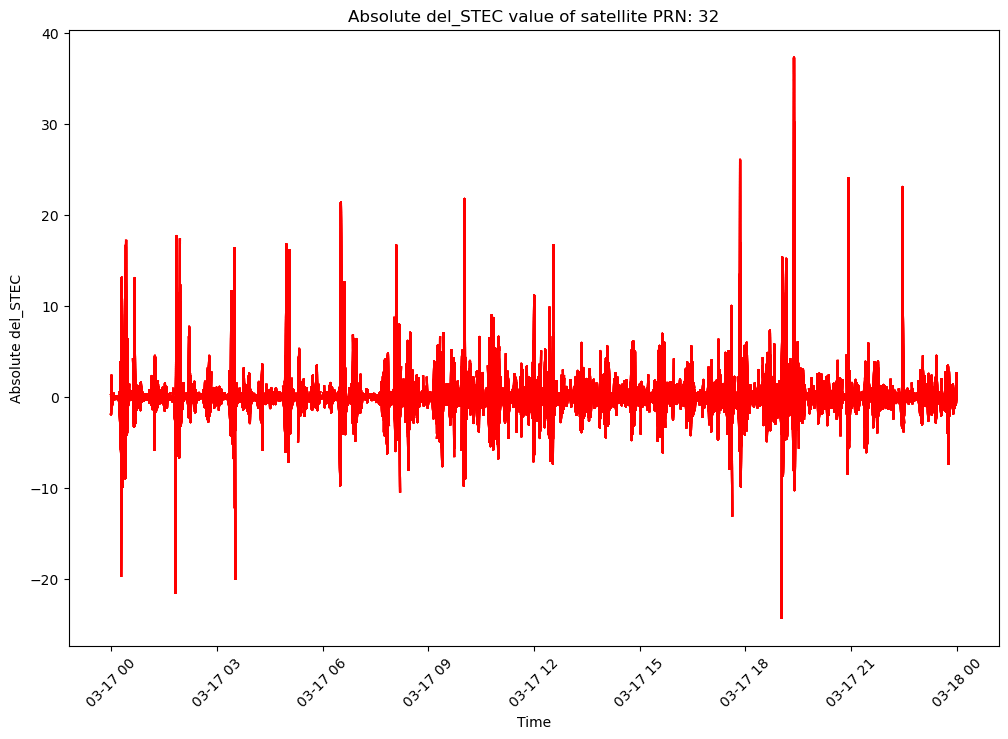

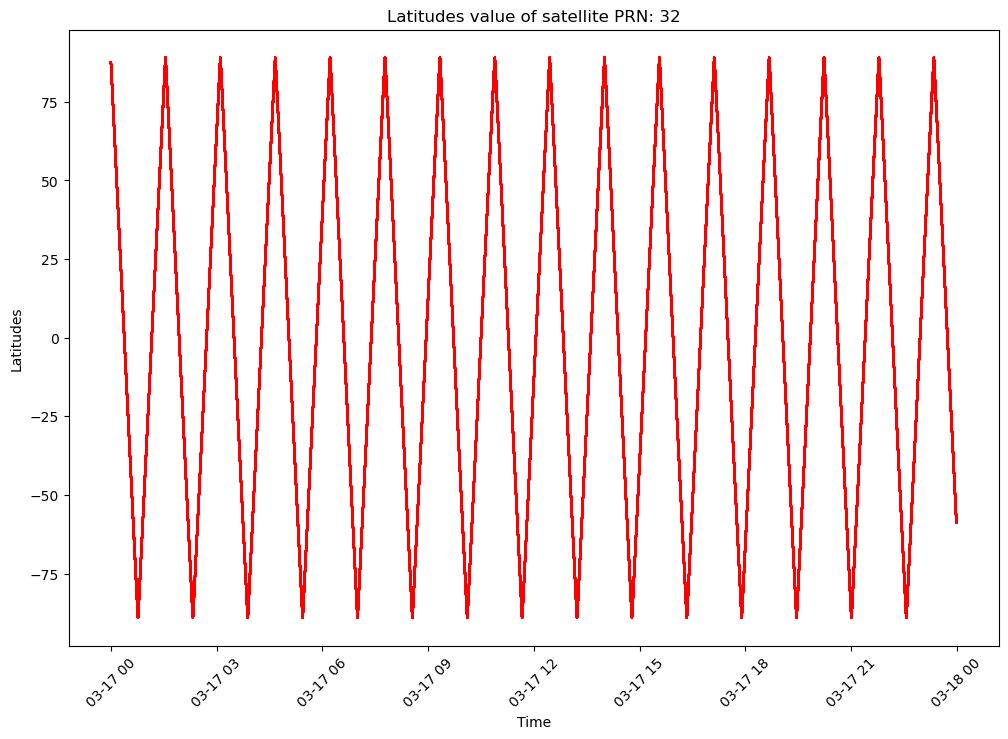

In [27]:
# print(out_stec[0])
#print(out_sdtec[0])
print(out_prn)
#p = 10

plt.figure(figsize=(12,8))
for p in out_prn:
    for i in range(len(out_prn)):
        if out_prn[i] == p:
            plt.plot(out_time[i], out_stec[i], color='red')
plt.title("Absolute STEC value of satellite PRN: " + str(p) + " and Plot's x-Scale: ~2100 points/hour")
plt.ylabel('Absolute STEC')
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.show()


plt.figure(figsize=(12,8))
for p in out_prn:
    for i in range(len(out_prn)):
        if out_prn[i] == p:
            plt.plot(out_time[i],out_sdtec[i], color='red')
plt.title('Absolute del_STEC value of satellite PRN: ' + str(p))
plt.ylabel('Absolute del_STEC')
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.show()

plt.figure(figsize=(12,8))
for p in out_prn:
    for i in range(len(out_prn)):
        if out_prn[i] == p:
            plt.plot(out_time[i],out_lat[i], color='red')
plt.title('Latitudes value of satellite PRN: ' + str(p))
plt.ylabel('Latitudes')
plt.xlabel('Time')
plt.xticks(rotation = 45)
plt.show()


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 2

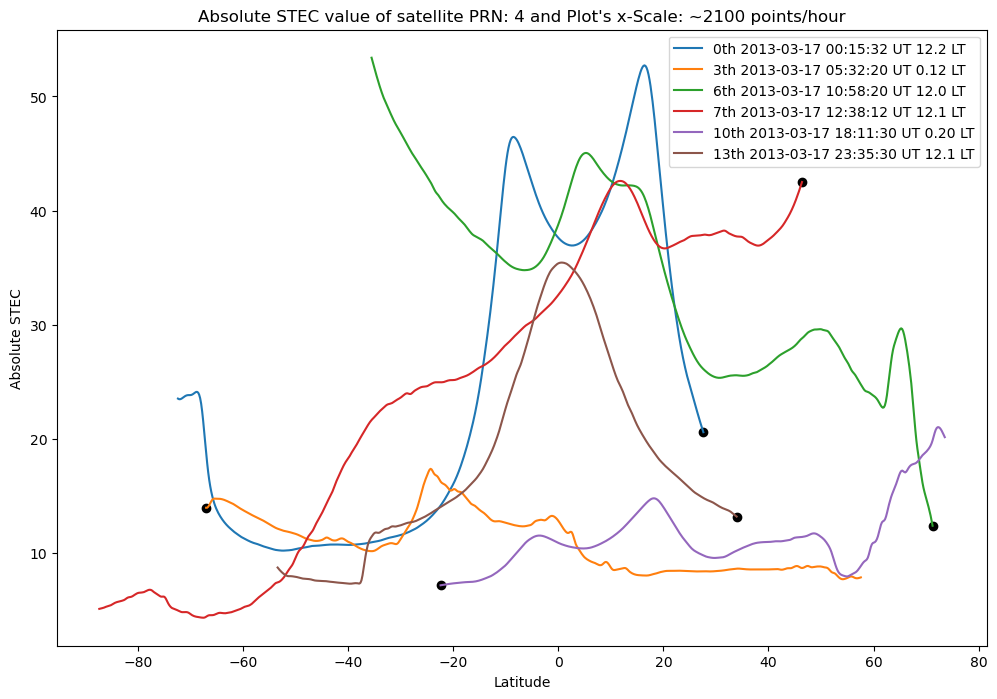

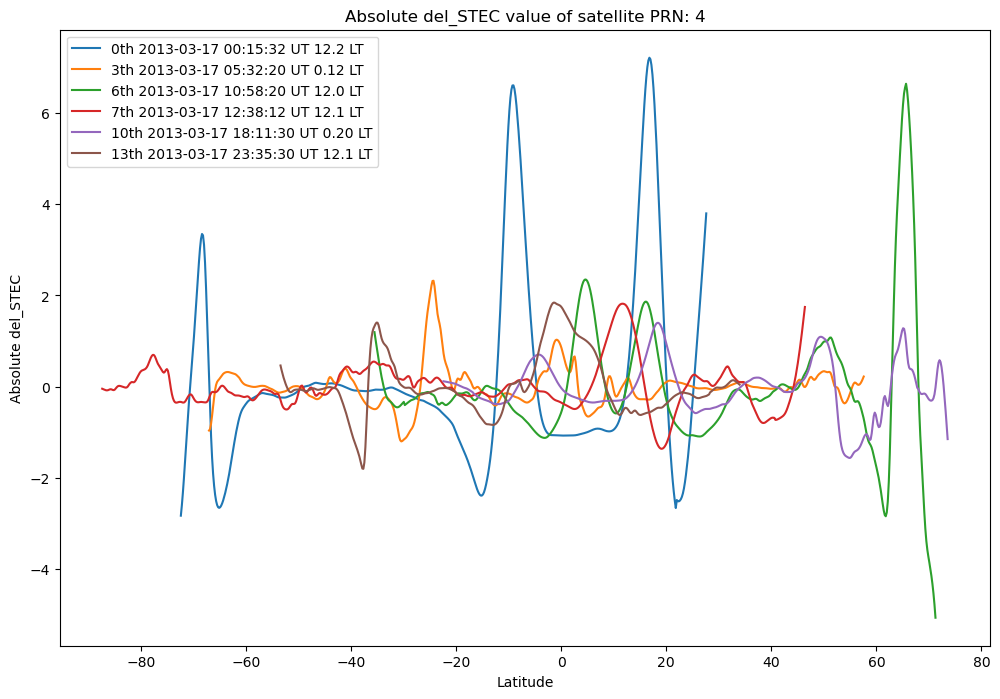

In [36]:
print(out_prn)
p = 4

proper_pass = []

#c = ['violet', 'blue', 'green', 'yellow', 'red']
j = 0
plt.figure(figsize=(12,8))
for i in range(len(out_prn)):
    if out_prn[i] == p:
        if ((max(out_lat[i]) + min(out_lat[i]))/2 > -30) and ((max(out_lat[i]) + min(out_lat[i]))/2 < 30): 
            plt.plot(out_lat[i], out_stec[i], label = str(j) + 'th '+ str(out_time[i][0])[:19] + ' UT ' + str(out_lt[i][0])[:4] +' LT')
            plt.scatter(out_lat[i][0], out_stec[i][0], color='black')
            proper_pass.append(i)
        j += 1
plt.title("Absolute STEC value of satellite PRN: " + str(p) + " and Plot's x-Scale: ~2100 points/hour")
plt.ylabel('Absolute STEC')
plt.xlabel('Latitude')
plt.legend()
#plt.xticks(rotation = 45)
plt.show()

j = 0
plt.figure(figsize=(12,8))
for i in range(len(out_prn)):
    if out_prn[i] == p:
        if ((max(out_lat[i]) + min(out_lat[i]))/2 > -30) and ((max(out_lat[i]) + min(out_lat[i]))/2 < 30): 
            plt.plot(out_lat[i],out_sdtec[i], label = str(j) + 'th ' + str(out_time[i][0])[:19] + ' UT ' + str(out_lt[i][0])[:4] +' LT')
        j += 1
plt.title('Absolute del_STEC value of satellite PRN: ' + str(p))
plt.ylabel('Absolute del_STEC')
plt.xlabel('Latitude')
plt.legend()
#plt.xticks(rotation = 45)
plt.show()

In [37]:
#purple brown in 31
ascending = []
descending = []
for i in proper_pass:
    if out_lat[i][0] < out_lat[i][-1]:
        ascending.append(i)
    else:
        descending.append(i)
print(ascending, descending)

[39, 46] [36, 42, 43, 49]


prn = 4


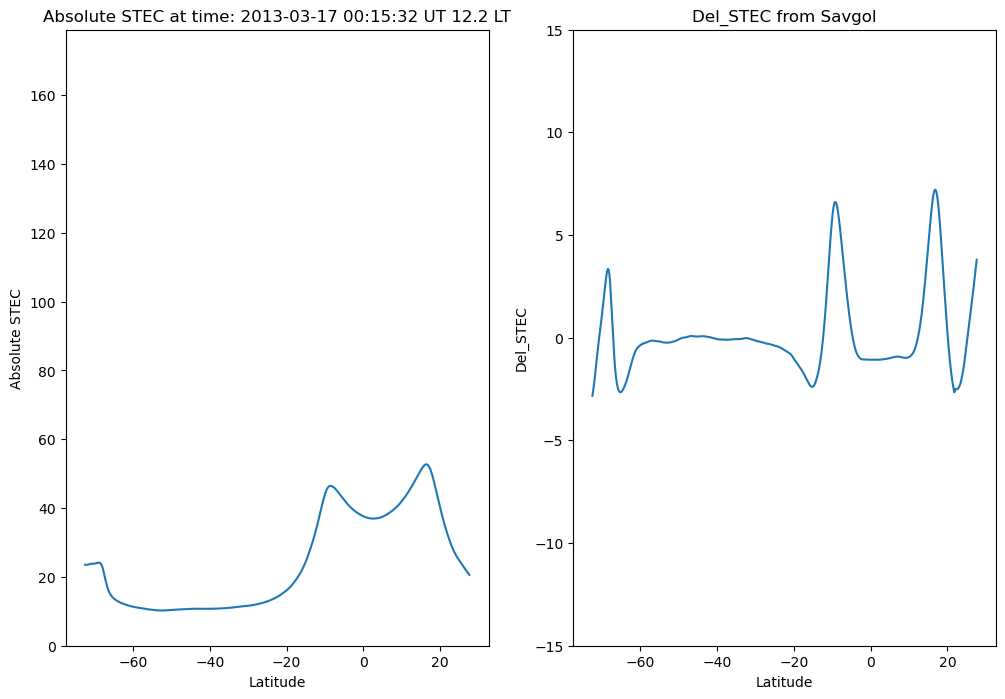

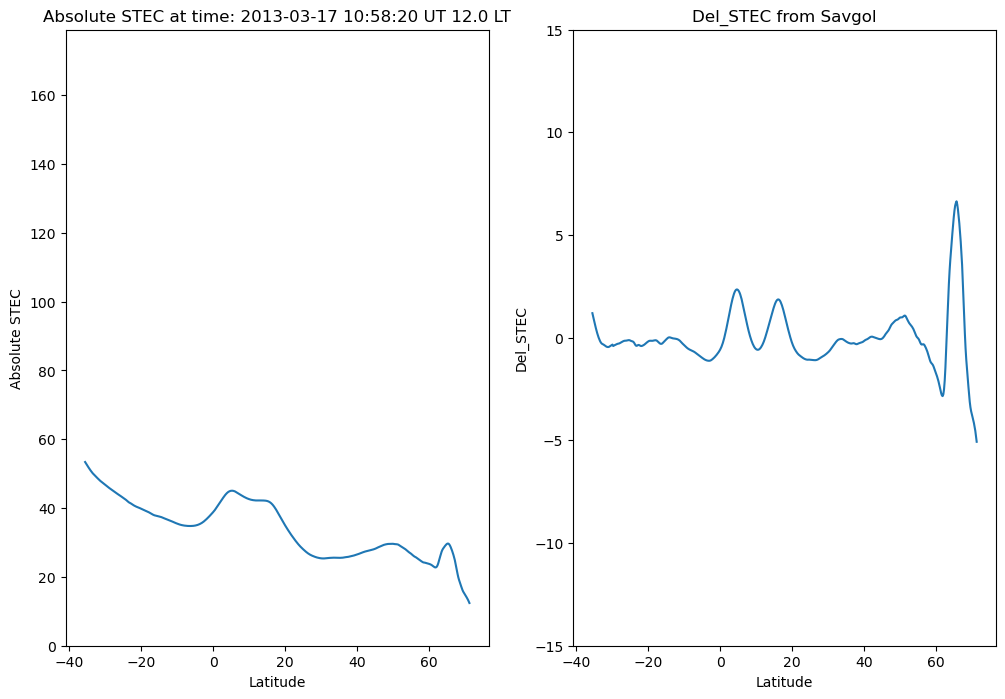

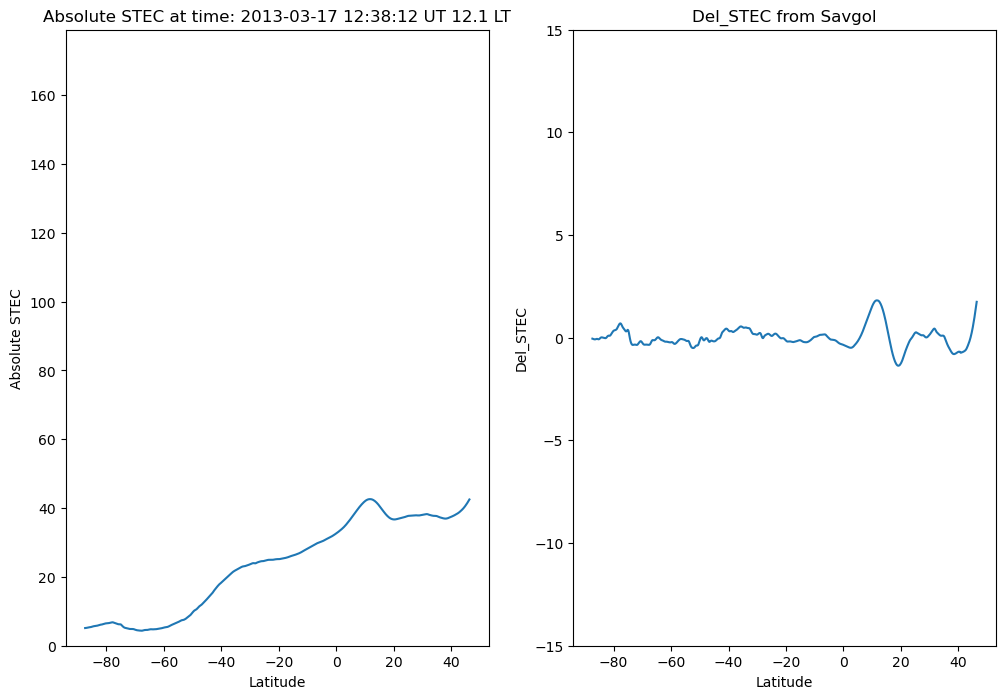

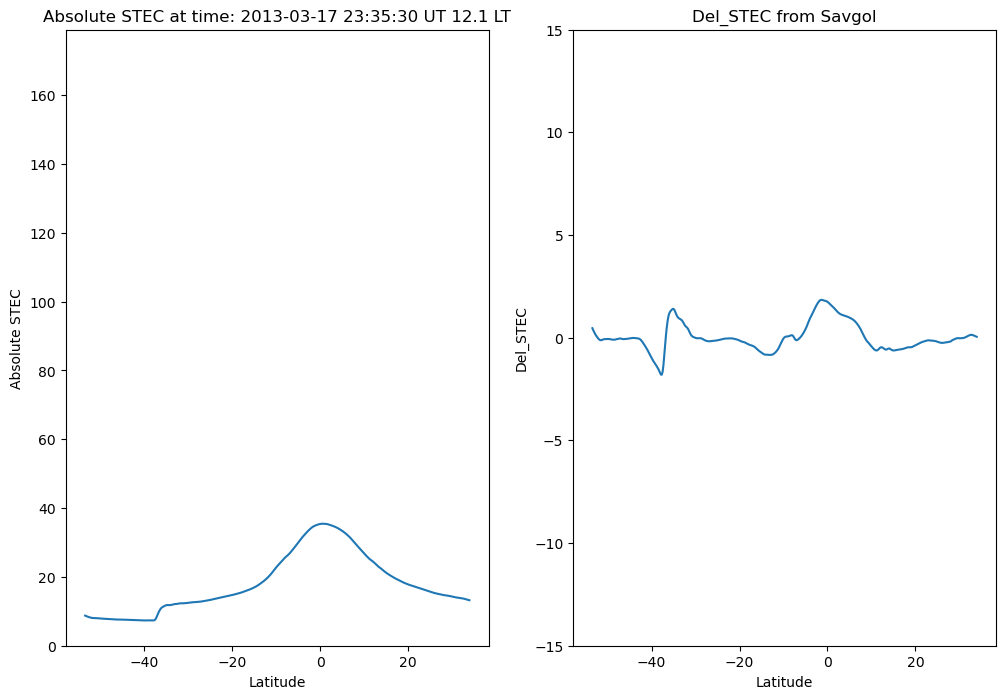

In [38]:
print('prn =', p)
w = 60
poly = 1
for i in descending:
    fit = savgol_filter(out_stec[i], w, poly, mode='interp')
    delta = out_stec[i]-fit
    
    fig, axs = plt.subplots(1,2, sharex=True, figsize=(12,8))
    axs[0].plot(out_lat[i], out_stec[i])
    axs[0].set_title('Absolute STEC at time: ' + str(out_time[i][0])[:19] + ' UT ' + str(out_lt[i][0])[:4] +' LT')
    axs[0].set_ylabel('Absolute STEC')
    axs[0].set_xlabel('Latitude')
    axs[0].set_ylim(0, max(d2['Absolute_STEC'].values))
    
    axs[1].plot(out_lat[i], delta)
    axs[1].set_title('Del_STEC from Savgol')
    axs[1].set_ylabel('Del_STEC')
    axs[1].set_xlabel('Latitude') 
    axs[1].set_ylim(-15, 15)
    
plt.xlabel('Latitude')
plt.show()

In [86]:
print(d1.date.dt.time.values[:10])

print(d1.data_vars)

[datetime.time(0, 0) datetime.time(0, 0) datetime.time(0, 0)
 datetime.time(0, 0) datetime.time(0, 0) datetime.time(0, 0)
 datetime.time(0, 0, 10) datetime.time(0, 0, 10) datetime.time(0, 0, 10)
 datetime.time(0, 0, 10)]
Data variables:
    Timestamp          (step) float64 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 88.73 88.73 88.73 ... -57.2 -57.2 -57.2
    Longitude          (step) float64 134.2 134.2 134.2 ... -175.1 -175.1 -175.1
    Radius             (step) float64 6.806e+06 6.806e+06 ... 6.825e+06
    GPS_Position_X     (step) float64 -6.162e+06 -1.878e+07 ... -3.354e+06
    GPS_Position_Y     (step) float64 1.532e+07 -1.001e+06 ... -2.177e+07
    GPS_Position_Z     (step) float64 2.075e+07 1.862e+07 ... -1.507e+07
    LEO_Position_X     (step) float64 -1.049e+05 -1.049e+05 ... -3.683e+06
    LEO_Position_Y     (step) float64 1.079e+05 1.079e+05 ... -3.128e+05
    LEO_Position_Z     (step) float64 6.804e+06 6.804e+06 ... -5.737e+06
    PRN          